# Unsupervised Ink Detection with DINO <a target="_blank" href="https://colab.research.google.com/github/jgcarrasco/dino-ink-detection/blob/main/pca_dino.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**MAKE SURE THAT YOU ARE RUNNING COLAB ON A GPU!** `Runtime Environment -> Change Runtime -> GPU or TPU`, whatever it works

In [ ]:
try:
    import google.colab
    from google.colab import output
    output.enable_custom_widget_manager()

    !git clone https://github.com/jgcarrasco/dino-ink-detection.git
    !mv dino-ink-detection/utils.py utils.py
    %pip install tifffile ipympl imagecodecs
except:
    %pip install tifffile ipympl imagecodecs torch numpy torchvision opencv-python scikit-learn

import os
import torch

from utils import load_segment, visualize_cropper, compute_PCA, visualize_PCA

model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
if torch.cuda.is_available():
    model = model.cuda()
model.eval()

%matplotlib widget

# Config

Below you can change several parameters. I recommend you to play with the number of PCA components and the crop size.

In [3]:
PCA_DEPTH = False # Whether to compute PCA across al layers, or layerwise. I obtained better results with layerwise (i.e. False)
N_COMPONENTS = 5 # Number of PCA components 
CROP_SIZE = 600 # Size of the crop that we want to compute PCA on. The crop size will be rounded to the smallest multiple of the patch size
PATCH_SIZE = 14 # patch size that the DINO model uses, do not change!
CROP_SIZE = (CROP_SIZE // PATCH_SIZE) * PATCH_SIZE

Now we are going to read the data, which has to be stored in the following format:

```
segments/
    segment_id/
        layers/
            00.tif
            ...
            64.tif
        segment_id_inklabels.png
        segment_id_mask.png
```

**NOTE:** This implementation is a really inefficient prototype! Try to load smaller segments first, below I provide different suggestions. For now, we will just work with the segment containing a letter Tau (I tried running Casey's pi on colab but it crashes due to limited RAM!)

In [4]:
segment_id = "20230519195952" # another small segment
#segment_id = "20230509182749" # casey pi's segment
#segment_id = "20231210121321" # small segment with lots of predicted letters. This starts to get larger and will not work in colab

The cell below will automatically download the segment:

In [ ]:
if not os.path.exists(f"segments/{segment_id}/layers"):
    os.makedirs(f"segments/{segment_id}/layers")
! wget -r -nH --cut-dirs=6 --no-parent --reject="index.html*" -P segments/{segment_id}/layers https://dl.ash2txt.org/full-scrolls/Scroll1/PHercParis4.volpkg/paths/{segment_id}/layers/
! wget -P segments/{segment_id} https://dl.ash2txt.org/full-scrolls/Scroll1/PHercParis4.volpkg/paths/{segment_id}/{segment_id}_mask.png
! wget -O segments/{segment_id}/{segment_id}_inklabels.png https://vesuvius.virtual-void.net/scroll/1/segment/{segment_id}/inferred/grand-prize_17_32/full

In [6]:
# load the segment
tif, inklabels = load_segment(segment_id)

Execute the cell below to visualize the segment. You can click on the segment to move the red square. Once that you have selected a region of your interest, press enter to crop it and keep following the notebook. Try to crop the whole region that was predicted as a tau! (**NOTE:** This works quite janky in colab, try resizing the plot window by draging the corner and way for a little)

interactive(children=(IntSlider(value=0, description='Slice', max=64), Output()), _dom_classes=('widget-intera…

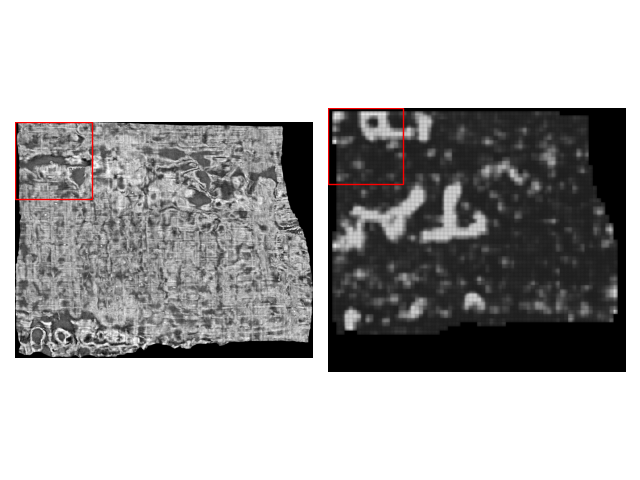

In [7]:
result = visualize_cropper(tif, inklabels, crop_size=CROP_SIZE)

Now we can compute the PCA vectors on the cropped region:

In [8]:
cropped_tif = result["cropped_tif"]
cropped_inklabels = result["cropped_inklabels"]
y_pca = compute_PCA(cropped_tif, model, PCA_DEPTH, n_components=N_COMPONENTS)

Finally, we visualize the results. Try to localize hints of the letter. If you cannot see anything, use the slider to **move through the different layers**, ensure that you have cropped the whole tau or try cropping a larger area. Now you can try visualizing other small segments/regions and try to discover letters!

In [10]:
visualize_PCA(y_pca, cropped_tif, cropped_inklabels)

interactive(children=(IntSlider(value=36, description='Slice Index', max=64), Output()), _dom_classes=('widget…